In [1]:

%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import LabelEncoder

import vis

import lightgbm as lgb

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import auc

from scipy import interp

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [2]:
train = pd.read_csv('../input/application_train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,...,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,...,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-815.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,Business Entity Type 3,NaN,0.650442,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,0.0,2.0,0.0,-617.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single /

In [3]:
test = pd.read_csv('../input/application_test.csv')

In [4]:
test.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,...,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,...,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976,-1866,-2000.0,-4208,NaN,1,1,0,1,1,0,Sales staff,4.0,2,2,WEDNESDAY,11,0,0,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.3052,0.1974,0.9970,0.9592,0.1165,0.32,0.2759,...,0.3081,0.1974,0.9970,0.9597,0.1173,0.32,0.2759,0.375,0.0417,0.2078,0.2446,0.3739,0.0388,0.0817,reg oper account,block of flats,0.3700,Panel,No,0.0,0.0,0.0,0.0,-1805.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
4,100038,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040,-2191,-4000.0,-4262,16.0

In [5]:
le = LabelEncoder()
le_count = 0

for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <= 2:
            le.fit(train[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            le_count += 1


In [6]:
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [7]:
train_df = pd.get_dummies(train)
test_df = pd.get_dummies(test)

In [8]:
print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [9]:
target = train_df['TARGET']

train_df, test_df = train_df.align(test_df, join='inner', axis=1)

train_df['TARGET'] = target

In [10]:
print('Training Features shape: ', train_df.shape)
print('Testing Features shape: ', test_df.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


In [11]:
train_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
test_df['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

In [12]:
train_df['CREDIT_INCOME_PERCENT'] = train_df['AMT_CREDIT'] / train_df['AMT_INCOME_TOTAL']
train_df['ANNUITY_INCOME_PERCENT'] = train_df['AMT_ANNUITY'] / train_df['AMT_INCOME_TOTAL']
train_df['CREDIT_TERM'] = train_df['AMT_ANNUITY'] / train_df['AMT_CREDIT']
train_df['DAYS_EMPLOYED_PERCENT'] = train_df['DAYS_EMPLOYED'] / train_df['DAYS_BIRTH']

In [13]:
test_df['CREDIT_INCOME_PERCENT'] = test_df['AMT_CREDIT'] / test_df['AMT_INCOME_TOTAL']
test_df['ANNUITY_INCOME_PERCENT'] = test_df['AMT_ANNUITY'] / test_df['AMT_INCOME_TOTAL']
test_df['CREDIT_TERM'] = test_df['AMT_ANNUITY'] / test_df['AMT_CREDIT']
test_df['DAYS_EMPLOYED_PERCENT'] = test_df['DAYS_EMPLOYED'] / test_df['DAYS_BIRTH']

In [14]:
if 'TARGET' in train_df:
    y_train = train_df['TARGET']
    X_train = train_df.drop(columns=['TARGET', 'SK_ID_CURR'])
else:
    X_train = train_df.copy()

features = X_train.columns.tolist()

X_test = test_df.drop(columns=['SK_ID_CURR']).copy()


In [15]:
print('Training data shape: ', X_train.shape)
print('Testing data shape: ', X_test.shape)

Training data shape:  (307511, 242)
Testing data shape:  (48744, 242)


In [16]:
folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1)


In [17]:

lgbm = lgb.LGBMClassifier(learning_rate=0.01,
                          n_estimators=1000,
                          objective='cross_entropy',
#                           max_depth=5
                         )

In [18]:
import re
X_train_copy = X_train.copy()
X_train_copy = X_train_copy.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '',x))

In [19]:
X_train_copy.shape

(307511, 242)

[50]	valid_0's auc: 0.728239	valid_0's cross_entropy: 0.264256
[100]	valid_0's auc: 0.734223	valid_0's cross_entropy: 0.257605
[150]	valid_0's auc: 0.740063	valid_0's cross_entropy: 0.253925
[200]	valid_0's auc: 0.746238	valid_0's cross_entropy: 0.251423
[250]	valid_0's auc: 0.750797	valid_0's cross_entropy: 0.249729
[300]	valid_0's auc: 0.753983	valid_0's cross_entropy: 0.248561
[350]	valid_0's auc: 0.756139	valid_0's cross_entropy: 0.247791
[400]	valid_0's auc: 0.757973	valid_0's cross_entropy: 0.247173
[450]	valid_0's auc: 0.759301	valid_0's cross_entropy: 0.246717
[500]	valid_0's auc: 0.760334	valid_0's cross_entropy: 0.246357
[550]	valid_0's auc: 0.761048	valid_0's cross_entropy: 0.246107
[600]	valid_0's auc: 0.761676	valid_0's cross_entropy: 0.245886
[650]	valid_0's auc: 0.761948	valid_0's cross_entropy: 0.245761
[700]	valid_0's auc: 0.762181	valid_0's cross_entropy: 0.245659
[750]	valid_0's auc: 0.762394	valid_0's cross_entropy: 0.245579
[800]	valid_0's auc: 0.762508	valid_0's c

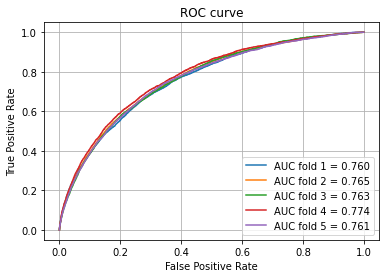

In [20]:
full_auc = []
test_preds = np.zeros(X_test.shape[0])
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X_train_copy, y_train)):
    X_tra, y_tra = X_train_copy.iloc[train_idx], y_train.iloc[train_idx]
    X_valid, y_valid = X_train_copy.iloc[valid_idx], y_train.iloc[valid_idx]
#     positive_count = y_tra.sum()
    
#     rus = RandomUnderSampler(random_state=1,
#                              sampling_strategy={0:positive_count*10, 1:positive_count})
#     X_train_re, y_train_re = rus.fit_resample(X_tra, y_tra)
    X_tra, X_val, y_tra, y_val=train_test_split(X_tra, y_tra, test_size=0.2, random_state=1, stratify=y_tra)
    pred = lgbm.fit(X_tra, y_tra,
                    eval_set=(X_val, y_val),
                    verbose=50,
                    eval_metric='auc').predict_proba(X_valid)[:, 1]
#     auc_score = roc_auc_score(y_valid, pred)
    fpr, tpr, thresholds = roc_curve(y_valid, pred)
    auc_score = roc_auc_score(y_valid, pred)
    
    full_auc.append(auc_score)
    
    #predict test data
    test_preds += lgbm.predict_proba(X_test)[:, 1]/folds.n_splits
    plt.plot(fpr, tpr, label='AUC fold %d = %.3f' % (n_fold+1, auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()
    

In [21]:
np.mean(full_auc)

0.7648342532921779

In [19]:
np.mean(full_auc)

0.7574980131643159

In [73]:
X_tra.shape

(196807, 238)

In [76]:
lgbm.get_params

<bound method LGBMModel.get_params of LGBMClassifier(learning_rate=0.01, n_estimators=1000, objective='cross_entropy')>

In [69]:
pred = lgbm.predict_proba(X_test)[:,1]

In [70]:
submit_df = pd.DataFrame({'SK_ID_CURR':test_df.SK_ID_CURR, 'TARGET':pred})

In [71]:
submit_df.head()

,SK_ID_CURR,TARGET
0,100001,0.047581
1,100005,0.104079
2,100013,0.022025
3,100028,0.031898
4,100038,0.139849


In [72]:
submit_df.to_csv('baseline_lightgbm.csv', index=False)